In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from object_classifier import TLClassifier
from vis_util import draw_bounding_boxes_on_image_array,draw_bounding_box_on_image_array
import matplotlib.pyplot as plt
from skimage.io import imread
import numpy as np

/Users/kanhua/miniconda3/envs/lyft-3d/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/kanhua/miniconda3/envs/lyft-3d/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/kanhua/miniconda3/envs/lyft-3d/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/kanhua/miniconda3/envs/lyft-3d

In [3]:
sample_image_file="/Users/kanhua/Downloads/3d-object-detection-for-autonomous-vehicles/train_images/host-a004_cam0_1232815253451064006.jpeg"

In [4]:
sample_image=imread(sample_image_file)

In [5]:
tlc=TLClassifier()

In [6]:
detected_box=tlc.detect_object(sample_image)

In [7]:
detected_box

array([0.5387009 , 0.6970206 , 0.73919636, 0.9997184 ], dtype=float32)

In [8]:
image_to_be_drawn=np.copy(sample_image)
draw_bounding_box_on_image_array(image_to_be_drawn,*detected_box)

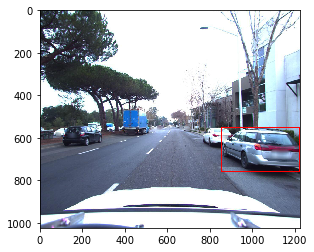

In [9]:
plt.imshow(image_to_be_drawn)

In [21]:
nboxes=tlc.detect_multi_object(sample_image,score_threshold=[0.6,0.8,0.8],rearrange_to_pointnet_convention=False)

In [22]:
nboxes

array([[0.53870088, 0.69702059, 0.73919636, 0.99971843, 0.99689227,
        0.        ],
       [0.5395968 , 0.62974864, 0.62879121, 0.74693775, 0.99453425,
        0.        ],
       [0.53419459, 0.0869122 , 0.62615567, 0.24842599, 0.9880113 ,
        0.        ],
       [0.53163904, 0.55594254, 0.55623484, 0.58231568, 0.82798791,
        0.        ],
       [0.54010063, 0.06270245, 0.58729607, 0.1034723 , 0.81646502,
        0.        ],
       [0.52096641, 0.18335815, 0.55677593, 0.23692986, 0.69809699,
        0.        ]])

In [12]:
#nboxes=rearrange_box_elements(bb)

In [13]:
nb=nboxes[0,0:4]
nb

array([ 853.15319824, 1223.65539551,  551.62969971,  756.93707275])

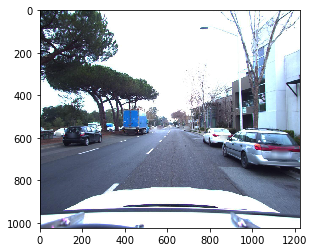

In [14]:
image_to_be_drawn=np.copy(sample_image)
draw_bounding_box_on_image_array(image_to_be_drawn,nb[2],nb[0],nb[3],nb[1])
plt.imshow(image_to_be_drawn)

In [25]:
nboxes.shape

(6, 6)

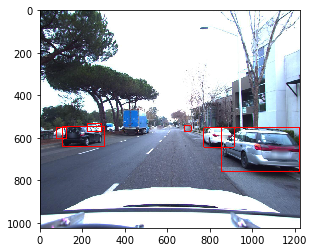

In [26]:
image_to_be_drawn=np.copy(sample_image)
draw_bounding_boxes_on_image_array(image_to_be_drawn,nboxes[:,0:4])
plt.imshow(image_to_be_drawn)

In [15]:
from prepare_lyft_data import level5data
from lyft_dataset_sdk.utils.geometry_utils import BoxVisibility
from lyft_dataset_sdk.utils.data_classes import Box

In [16]:
def select_annotation_boxes(sample_token, box_vis_level: BoxVisibility = BoxVisibility.ALL,
                            camera_type=['CAM_FRONT']) -> (str, str, Box):
    """
    Select annotations that is a camera image defined by box_vis_level


    :param sample_token:
    :param box_vis_level:BoxVisbility.ALL or BoxVisibility.ANY
    :param camera_type: a list of camera that the token should be selected from
    :return: yield (sample_token,cam_token, Box)
    """
    sample_record = level5data.get('sample', sample_token)

    cams = [key for key in sample_record["data"].keys() if "CAM" in key]
    cams = [cam for cam in cams if cam in camera_type]
    for ann_token in sample_record['anns']:
        for cam in cams:
            cam_token = sample_record["data"][cam]
            _, boxes_in_sensor_coord, cam_intrinsic = level5data.get_sample_data(
                cam_token, box_vis_level=box_vis_level, selected_anntokens=[ann_token]
            )
            if len(boxes_in_sensor_coord) > 0:
                assert len(boxes_in_sensor_coord) == 1
                box_in_world_coord = level5data.get_box(boxes_in_sensor_coord[0].token)
                yield sample_token, cam_token, box_in_world_coord

In [17]:
from lyft_dataset_sdk.lyftdataset import LyftDataset
def select_2d_annotation_boxes(ldf: LyftDataset, classifier, sample_token,
                               camera_type=['CAM_FRONT']) -> (str, str, np.ndarray):
    sample_record = ldf.get('sample', sample_token)

    cams = [key for key in sample_record["data"].keys() if "CAM" in key]
    cams = [cam for cam in cams if cam in camera_type]
    for cam in cams:
        cam_token = sample_record["data"][cam]
        image_file_path = ldf.get_sample_data_path(cam_token)
        image_array = imread(image_file_path)
        det_result = classifier.detect_multi_object(image_array, score_threshold=[0.6, 0.8, 0.8])
        for i in range(det_result.shape[0]):
            bounding_2d_box = det_result[i, 0:4]
            score = det_result[i, 4]
            class_idx = det_result[i, 5]
            yield sample_token, cam_token, bounding_2d_box, score, class_idx

In [18]:
def get_all_boxes_in_single_scene(scene_number, from_rgb_detection, ldf: LyftDataset):
    results = []
    start_sample_token = ldf.scene[scene_number]['first_sample_token']
    sample_token = start_sample_token
    while sample_token != "":
        sample_record = ldf.get('sample', sample_token)
        if not from_rgb_detection:
            for tks in select_annotation_boxes(sample_token, lyftd=ldf):
                results.append(tks)
        else:
            for tks in select_2d_annotation_boxes(ldf, classifier=tlc, sample_token=sample_token):
                results.append(tks)

        next_sample_token = sample_record['next']
        sample_token = next_sample_token

    return results

In [19]:
first_sample_token=level5data.scene[0]['first_sample_token']

In [20]:
det=select_2d_annotation_boxes(level5data,tlc,first_sample_token)

In [35]:
det=list(det)
for i in det:
    print(i)

In [36]:
dets=get_all_boxes_in_single_scene(0,from_rgb_detection=True,ldf=level5data)

In [37]:
len(dets)

460

In [38]:
tk='24b0962e44420e6322de3f25d9e4e5cc3c7a348ec00bfa69db21517e4ca92cc8'

In [39]:
lidar_token=level5data.get('sample',tk)['data']['LIDAR_TOP']
camera_token=level5data.get('sample',tk)['data']['CAM_FRONT']

In [40]:
from prepare_lyft_data import get_pc_in_image_fov

In [48]:
result=get_pc_in_image_fov(lidar_token,camera_type='CAM_FRONT',lyftd=level5data,bounding_box=dets[0][2])

In [49]:
result[0]

array([False, False, False, ..., False, False, False])

In [50]:
np.sum(result[0])

1519